<a href="https://colab.research.google.com/github/Galahexolion/Giliojo-mokymo-sistem-taikymai/blob/main/Lab7/Lab7_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- 1. DATA EXPLORATION ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

# Įkeliame jūsų failą
df = pd.read_csv('lab_data.csv')

print("Duomenų pavyzdys:")
print(df.head())

# Vizualizacija (Plotly)
def plot_timeseries(date, value, title="Time Series Data"):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=date, y=value, mode='lines', name='Value', line=dict(color='black', width=1)))
    fig.update_layout(title=title, plot_bgcolor='white',
                      xaxis=dict(showline=True, showgrid=True, linecolor='black'),
                      yaxis=dict(showline=True, showgrid=True, linecolor='black'))
    fig.show()

plot_timeseries(df['Date'], df['MedTemp'], "Median Daily Temperatures")

Duomenų pavyzdys:
         Date  MedTemp
0  2007-11-01    16.15
1  2007-11-02    20.45
2  2007-11-03    18.55
3  2007-11-04    14.40
4  2007-11-05    11.85


In [2]:
# --- 2. DATA PREPARATION ---

# Normalizavimas (Svarbu RNN!)
scaler = MinMaxScaler(feature_range=(0, 1))
data_values = df['MedTemp'].values.reshape(-1, 1)
data_scaled = scaler.fit_transform(data_values)

# Train/Test Split (SVARBU: shuffle=False laiko eilutėms!)
train_size = int(len(data_scaled) * 0.8)
train_data, test_data = data_scaled[0:train_size], data_scaled[train_size:len(data_scaled)]

print(f"Mokymo aibė: {len(train_data)}, Testavimo aibė: {len(test_data)}")


# Funkcija suformuoti sekas (Windowing)
# time_steps = kiek dienų atgal žiūrime, kad prognozuotume rytojų
def create_sequences(dataset, time_steps=7):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        X.append(dataset[i:(i + time_steps), 0])
        y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 14 # Žiūrime 2 savaites atgal
X_train, y_train = create_sequences(train_data, time_steps)
X_test, y_test = create_sequences(test_data, time_steps)

# Reshape į [samples, time_steps, features] (Būtina RNN/LSTM)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"X_train shape: {X_train.shape}")

Mokymo aibė: 2742, Testavimo aibė: 686
X_train shape: (2728, 14, 1)



--- Mokomas modelis: SimpleRNN ---
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
SimpleRNN MSE: 6.4476

--- Mokomas modelis: LSTM ---
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
LSTM MSE: 5.7594

--- Mokomas modelis: Stacked_GRU ---
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Stacked_GRU MSE: 5.6684


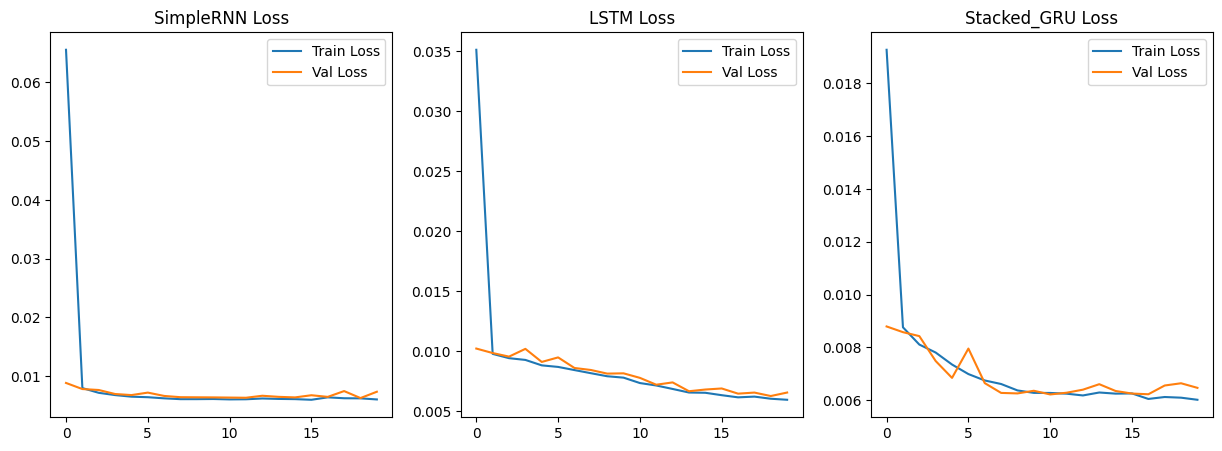

In [3]:
# --- 3. NEURAL NETWORK - 3 DIFFERENT STRUCTURES ---

def create_rnn_model(model_type):
    model = keras.Sequential()
    model.add(layers.Input(shape=(time_steps, 1)))

    if model_type == "SimpleRNN":
        # 1. Paprastas RNN (greitas, bet turi atminties problemų su ilgais ryšiais)
        model.add(layers.SimpleRNN(units=32, activation='tanh'))

    elif model_type == "LSTM":
        # 2. LSTM (Long Short-Term Memory) - standartas laiko eilutėms
        model.add(layers.LSTM(units=50, return_sequences=False))

    elif model_type == "Stacked_GRU":
        # 3. GRU (Gated Recurrent Unit) - panašus į LSTM, bet greitesnis
        # Stacked = keli sluoksniai vienas po kito
        model.add(layers.GRU(units=50, return_sequences=True)) # Būtina return_sequences=True, jei kitas sluoksnis RNN
        model.add(layers.Dropout(0.2))
        model.add(layers.GRU(units=25))

    model.add(layers.Dense(1)) # Išėjimas - viena reikšmė (prognozė)

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

structures = ["SimpleRNN", "LSTM", "Stacked_GRU"]
results = {}

plt.figure(figsize=(15, 5))

for i, struct in enumerate(structures):
    print(f"\n--- Mokomas modelis: {struct} ---")
    model = create_rnn_model(struct)

    history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0, validation_data=(X_test, y_test))

    # Prognozė
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Atstatome skalę (Inverse Transform), kad matytume realias temperatūras
    test_predict_inv = scaler.inverse_transform(test_predict)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Vertinimas
    mse = mean_squared_error(y_test_inv, test_predict_inv)
    results[struct] = mse
    print(f"{struct} MSE: {mse:.4f}")

    # Braižome Loss
    plt.subplot(1, 3, i+1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{struct} Loss')
    plt.legend()

plt.show()

In [4]:
# --- 4. EVALUATION & VISUALIZATION (Best Model) ---

best_model_name = min(results, key=results.get)
print(f"\nGeriausias modelis: {best_model_name}")

# Sukuriame ir apmokome geriausią modelį iš naujo (vizualizacijai)
final_model = create_rnn_model(best_model_name)
final_model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)

predictions = final_model.predict(X_test)
predictions_inv = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Grafikas: Tikra vs Prognozuota
fig = go.Figure()
fig.add_trace(go.Scatter(y=y_test_inv.flatten(), mode='lines', name='Actual', line=dict(color='blue')))
fig.add_trace(go.Scatter(y=predictions_inv.flatten(), mode='lines', name='Predicted', line=dict(color='red')))
fig.update_layout(title=f"Predictions using {best_model_name}", xaxis_title="Time Steps", yaxis_title="Temperature")
fig.show()

print(f"MAE (Mean Absolute Error): {mean_absolute_error(y_test_inv, predictions_inv):.4f}")
print(f"MSE (Mean Squared Error): {mean_squared_error(y_test_inv, predictions_inv):.4f}")


Geriausias modelis: Stacked_GRU
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


MAE (Mean Absolute Error): 1.8021
MSE (Mean Squared Error): 5.4579
